<a href="https://colab.research.google.com/github/yudam-J/KDC-classification-with-BERT/blob/main/KDC_classification(KoBERT_%EC%B5%9C%EC%86%8C%EB%A0%88%EC%BD%94%EB%93%9C_25_2_13).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Functions & Module Import

In [ ]:
!pip uninstall torch torchvision -y
!pip install torch==2.1.0 torchvision==0.16.0 --no-cache-dir

Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 167.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 173.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 192.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 173.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 181.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 218.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 224.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 260.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 217.5 MB/s eta 0:00:00
   

In [ ]:
import pandas as pd
import os
import sys
import urllib.request
import json
import re
import numpy as np
from google.colab import drive
from glob import glob

drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/work_dir')

pd.set_option('display.float_format', '{:.0f}'.format)

Mounted at /content/drive/


In [ ]:
def get_book_descriptions(df, isbn_column, client_id, client_secret):
    """
    네이버 책 API를 통해 ISBN 번호를 바탕으로 책 설명을 가져오는 함수.

    Parameters:
    - df (pd.DataFrame): ISBN 번호가 있는 데이터프레임
    - isbn_column (str): ISBN 번호가 포함된 열의 이름
    - client_id (str): 네이버 API 클라이언트 ID
    - client_secret (str): 네이버 API 클라이언트 시크릿

    Returns:
    - pd.DataFrame: description 열이 추가된 데이터프레임
    """
    descriptions = []

    for isbn in df[isbn_column]:
        query = urllib.parse.quote(isbn)

        # 네이버 API URL
        url = f"https://openapi.naver.com/v1/search/book_adv?d_isbn={query}&display=1&start=1&sort=sim"

        # 요청 헤더 설정
        request = urllib.request.Request(url)
        request.add_header("X-Naver-Client-Id", client_id)
        request.add_header("X-Naver-Client-Secret", client_secret)

        try:
            # API 요청 보내기
            response = urllib.request.urlopen(request)
            rescode = response.getcode()

            if rescode == 200:
                # 응답 본문 읽기
                response_body = response.read()
                items = json.loads(response_body.decode('utf-8')).get("items", [])

                # HTML 태그 제거용 정규 표현식
                remove_tag = re.compile('<.*?>')

                # 책의 description 가져오기 (첫 번째 검색 결과)
                description = re.sub(remove_tag, '', items[0]['description']) if items else "No description available"
                descriptions.append(description)
            else:
                print(f"Error Code: {rescode}")
                descriptions.append("Error in fetching description")

        except urllib.error.HTTPError as e:
            print(f"HTTP Error: {e.code}")
            descriptions.append("HTTP Error")
        except urllib.error.URLError as e:
            print(f"URL Error: {e.reason}")
            descriptions.append("URL Error")
        except Exception as e:
            print(f"General Error: {str(e)}")
            descriptions.append("General Error")

    # DataFrame에 descriptions 열 추가
    df['description'] = descriptions

    return df

#Data Preprocessing

## (1) Data Load and Combine

In [ ]:
"""
지정된 경로의 파일을 불러와 하나의 데이터프레임으로 병합합니다.
"""
csv_files = glob(os.path.join('/content/drive/MyDrive/work_dir', "NL_BO_SPECIES_MASTER_NEW*.csv"))

# 각 파일을 읽고 리스트에 추가하여 병합
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# 모든 데이터를 하나의 데이터프레임으로 결합
df_2 = pd.concat(dataframes, ignore_index=True)

<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (6,11,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (6,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (11,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (1,6,7,9,10,11,12,13,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-4-15d402cc761f>:9: DtypeWarning: Columns (1,7,10,11,12,13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read

In [ ]:
df_2.columns

Index(['SEQ_NO', 'ISBN_THIRTEEN_NO', 'VLM_NM', 'TITLE_NM', 'AUTHR_NM',
       'PUBLISHER_NM', 'PBLICTE_DE', 'ADTION_SMBL_NM', 'PRC_VALUE',
       'IMAGE_URL', 'BOOK_INTRCN_CN', 'KDC_NM', 'TITLE_SBST_NM',
       'AUTHR_SBST_NM', 'TWO_PBLICTE_DE', 'INTNT_BOOKST_BOOK_EXST_AT',
       'PORTAL_SITE_BOOK_EXST_AT', 'ISBN_NO'],
      dtype='object')

In [ ]:
df_2 = df_2[["TITLE_NM", "ISBN_THIRTEEN_NO", "BOOK_INTRCN_CN", "KDC_NM"]]

In [ ]:
df_2 = df_2.dropna(subset=['KDC_NM'])
nan_count_per_column = df_2.isna().sum()
print(nan_count_per_column)

TITLE_NM                  0
ISBN_THIRTEEN_NO          0
BOOK_INTRCN_CN      1392396
KDC_NM                    0
dtype: int64


In [ ]:
df_2 = df_2.dropna(subset=['BOOK_INTRCN_CN'])
nan_count_per_column = df_2.isna().sum()
print(nan_count_per_column)

TITLE_NM            0
ISBN_THIRTEEN_NO    0
BOOK_INTRCN_CN      0
KDC_NM              0
dtype: int64


In [ ]:
df_2.shape

(1050904, 4)

In [ ]:
df_2 = df_2.drop_duplicates(subset=['ISBN_THIRTEEN_NO'])
df_2.shape

(860476, 4)

In [ ]:
duplicate_counts = df_2['BOOK_INTRCN_CN'].value_counts()
# 중복된 값만 필터링 (2번 이상 나타나는 값)
duplicates = duplicate_counts[duplicate_counts > 1]

print(duplicates)

BOOK_INTRCN_CN
[해외주문원서] 고객님의 요청으로 수입 주문하는 도서이므로, 주문취소 및 반품이 불가합니다. (단, 재고부족인 경우는 가능)                                                                                                                 4966
이 책은 해당 분야 전공자들을 위한 교재 겸 전문서이다.                                                                                                                                                        255
▶ 이 책은 영어로 구성되어 있습니다.                                                                                                                                                                  208
어린이들을 위한 음악교재이다. 어린이들이 쉽게 따라할 수 있도록 구성되어 있다.                                                                                                                                           199
명문대 선정 세계문학 시리즈. 우리 나라의 대표적인 아동문학가들이 초등학교 아이들이 읽기에 알맞은 작품을 선정, 다듬어 실었다. 또 책 뒤에는 명문대학 국문과 교수들이 해설한 작가의 작품론과 철학과 교수들이 출제한 논술 길잡이를 수록했다.                                                  142
                                                  

In [ ]:
# 삭제할 행을 찾기 위한 조건 설정
df_2 = df_2[df_2['BOOK_INTRCN_CN'] != "[해외주문원서] 고객님의 요청으로 수입 주문하는 도서이므로, 주문취소 및 반품이 불가합니다. (단, 재고부족인 경우는 가능)"]
df_2.shape

(855510, 4)

In [ ]:
df_2.rename(columns={"BOOK_INTRCN_CN": "description"}, inplace=True)

<ipython-input-13-64fb631bd86b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.rename(columns={"BOOK_INTRCN_CN": "description"}, inplace=True)


In [ ]:
df_2.columns

Index(['TITLE_NM', 'ISBN_THIRTEEN_NO', 'description', 'KDC_NM'], dtype='object')

In [ ]:
df.columns

Index(['SEQ_NO', 'ISBN_THIRTEEN_NO', 'VLM_NM', 'TITLE_NM', 'AUTHR_NM',
       'PUBLISHER_NM', 'PBLICTE_DE', 'ADTION_SMBL_NM', 'PRC_VALUE',
       'IMAGE_URL', 'BOOK_INTRCN_CN', 'KDC_NM', 'TITLE_SBST_NM',
       'AUTHR_SBST_NM', 'TWO_PBLICTE_DE', 'INTNT_BOOKST_BOOK_EXST_AT',
       'PORTAL_SITE_BOOK_EXST_AT', 'ISBN_NO'],
      dtype='object')

In [ ]:
!pip install transformers torch

In [ ]:
def load_and_combine_csv(directory_path):
    """
    지정된 경로의 chunk*.csv 파일을 불러와 하나의 데이터프레임으로 병합합니다.
    """
    csv_files = glob(os.path.join(directory_path, "chunk*.csv"))

    # 각 파일을 읽고 리스트에 추가하여 병합
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)

    # 모든 데이터를 하나의 데이터프레임으로 결합
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

In [ ]:
combined_df = load_and_combine_csv("/content/drive/MyDrive/work_dir")
combined_df

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM,description
0,(청소년 지도사가 쓴)청소년복지론,9788991495227,338,No description available
1,펀드보다 안전한 가치 투자=:,9788957820285,328,No description available
2,지식의 발견=:,9788976829511,309,『지식의 발견』은 출판 담당 기자 출신의 저자가 한국의 대표적 지식인들이 근대성과 ...
3,육경과 공자 인학=(The)six books and Confucius jenlogy,9788976461742,152,이 책은 해당 분야 전공자들을 위한 교재 겸 전문서이다.
4,나노테크놀러지 최전선 기술,9788970442372,530,나노 과학과 기술에 관심이 있는 사람을 위해 나노과학의 첨단을 달리고 있는 일본의 ...
...,...,...,...,...
137695,생쥐 각시 시집가네,9788953515130,375,No description available
137696,산에 산에 가다가,9788953515154,375,No description available
137697,자장자장 잘도 잔다,9788953515161,375,No description available
137698,사또네 잔칫날,9788953515178,375,No description available


In [ ]:
combined_df = combined_df[combined_df['description'] != "No description available"]
combined_df

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM,description
2,지식의 발견=:,9788976829511,309,『지식의 발견』은 출판 담당 기자 출신의 저자가 한국의 대표적 지식인들이 근대성과 ...
3,육경과 공자 인학=(The)six books and Confucius jenlogy,9788976461742,152,이 책은 해당 분야 전공자들을 위한 교재 겸 전문서이다.
4,나노테크놀러지 최전선 기술,9788970442372,530,나노 과학과 기술에 관심이 있는 사람을 위해 나노과학의 첨단을 달리고 있는 일본의 ...
17,고분미술,9788981337414,609,"인간의 죽음에 대하여 의미를 부여하고, 또 죽음을 애도하는 과정에서 생겨난 상장례와..."
18,고분미술,9788981337421,609,옛 무덤에서 발견되는 유물은 단순한 유물이 아닌 당대의 문화의 산물입니다. 때문에 ...
...,...,...,...,...
137667,(피라미드에서 우주선까지)세계의 불가사의,9788952738349,31,바빌론의 공중 정원은 왜 만들어졌을까? 콜로서스의 로도스 상은 언제 무너졌을까? 알...
137671,달콤 쌉싸름한 초콜릿,9788937461088,873,22년동안 이어진 애절한 사랑 이야기!\n\n멕시코의 소설가 라우라 에스키벨의 첫 ...
137677,정부와 NGO,9788918021683,339,NaN
137680,응력해석 및 재료거동학,9788971416204,530,NaN


In [ ]:
# 기존 구축 데이터 병합
combined_df = pd.concat([combined_df, df_2], ignore_index=True)

In [ ]:
combined_df.shape

(943508, 4)

In [ ]:
combined_df = combined_df.drop_duplicates(subset='ISBN_THIRTEEN_NO', keep='first').reset_index(drop=True)

In [ ]:
combined_df.shape

(919595, 4)

In [ ]:
combined_df.isna().sum()

,0
TITLE_NM,0
ISBN_THIRTEEN_NO,0
KDC_NM,0
description,2515


In [ ]:
combined_df = combined_df.dropna(subset=['description'])

In [ ]:
combined_df.dtypes

,0
TITLE_NM,object
ISBN_THIRTEEN_NO,object
KDC_NM,object
description,object


## (2) 라벨 불균형 해결

In [ ]:
combined_df['KDC_NM'] = combined_df['KDC_NM'].astype(str).str.strip().str.replace(" ", "", regex=True)
combined_df['KDC_NM'] = combined_df['KDC_NM'].astype(str)

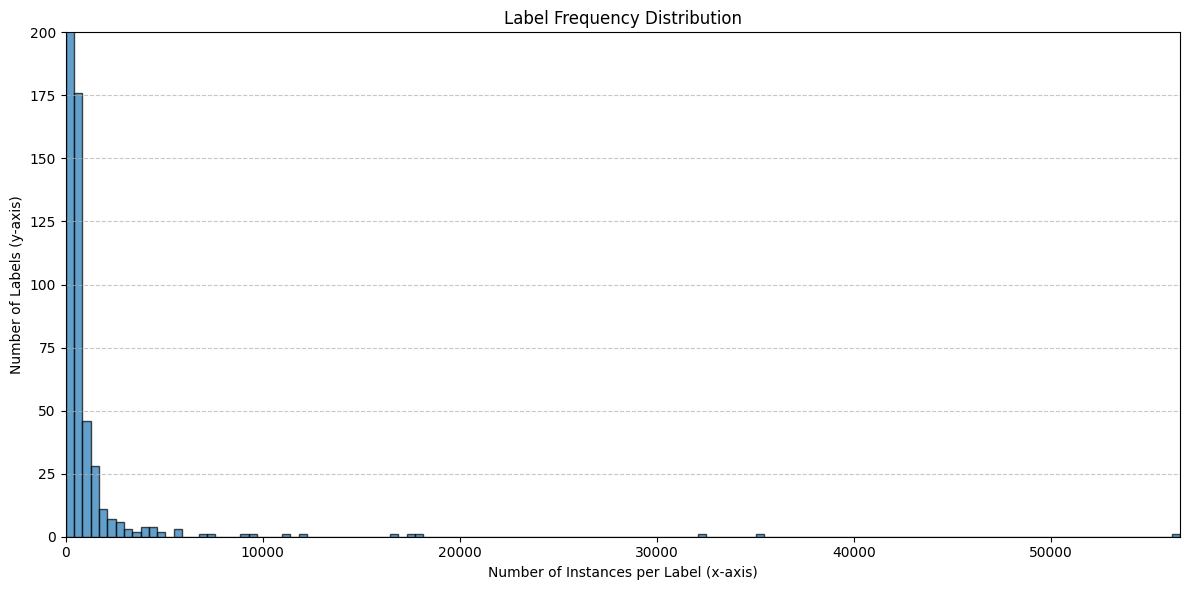

In [ ]:
from collections import Counter  # Counter 객체를 collections 모듈에서 임포트
import matplotlib.pyplot as plt # Import matplotlib

# 각 라벨의 빈도수 계산
label_counts = Counter(combined_df['KDC_NM'])

# 라벨의 빈도수 (x축에 해당)
label_frequencies = list(label_counts.values())

# 적절한 bin 개수 결정 (빈도수의 분포를 기준으로)
n_bins = int(np.sqrt(len(label_frequencies)))  # 빈도수에 대해 제곱근 법칙 적용

# 라벨 빈도수로 히스토그램 구간 설정
plt.figure(figsize=(12, 6))

# 히스토그램 그리기
plt.hist(
    label_frequencies,  # 라벨 빈도수 사용
    bins=n_bins,  # 동적으로 계산된 bin 개수
    edgecolor='black',
    alpha=0.7
)

# x축 최대값을 label_frequencies의 최댓값으로 설정
plt.xlim(0, max(label_frequencies))
plt.ylim(0, 200)

# 그래프 설정
plt.title('Label Frequency Distribution')
plt.xlabel('Number of Instances per Label (x-axis)')
plt.ylabel('Number of Labels (y-axis)')

# x축에 라벨 빈도수 표시, y축에는 레이블 개수 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
label_counts = Counter(combined_df['KDC_NM'])
labels_over_4000 = {label for label, count in label_counts.items() if count > 4000}

# 필터링하여 새로운 데이터프레임 생성
df_over4000 = combined_df[combined_df['KDC_NM'].isin(labels_over_4000)].copy()

# 결과 확인
print(df_over4000.shape)
print(df_over4000['KDC_NM'].value_counts())
print(len(df_over4000['KDC_NM'].value_counts()))

(288949, 4)
KDC_NM
813.7      56540
813.6      35036
830.0      32274
843.0      17811
833.6      17427
811.7      16841
818.0      12151
410.0      11279
810.0       9428
375.1       9256
747.0       7325
813.8       6788
811.6       5871
325.337     5819
843.6       5783
863.0       4737
740.77      4730
814.7       4469
740.0       4347
199.1       4337
400.0       4271
911.0       4154
325.211     4139
234.8       4136
Name: count, dtype: int64
24


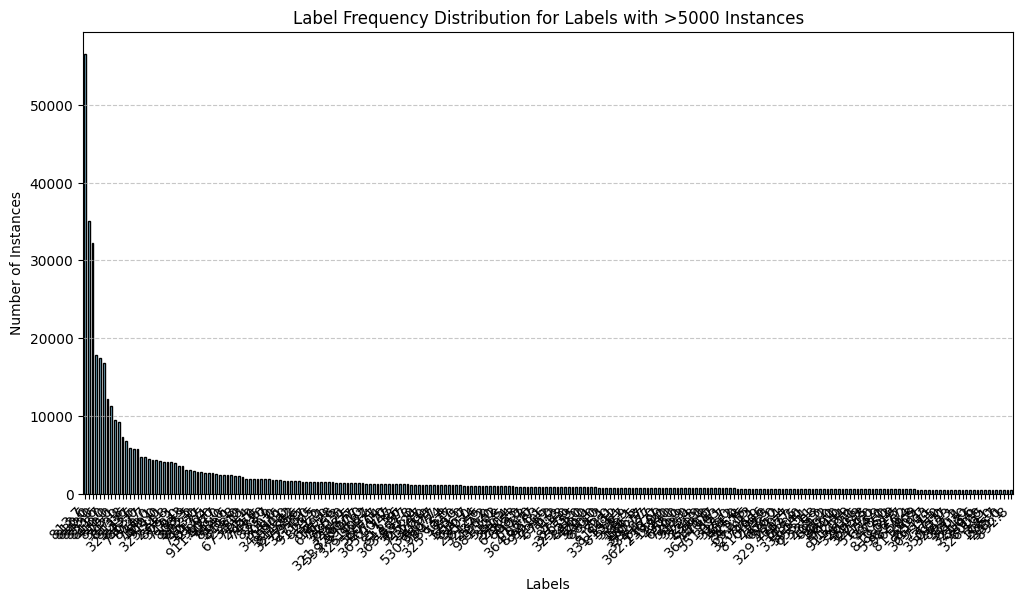

In [ ]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
df_over500['KDC_NM'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Frequency Distribution for Labels with >5000 Instances')
plt.xlabel('Labels')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Data Augmentation

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
import random
import pickle
import re

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words

def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)

	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return

	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

In [ ]:
def augment_data(data, label_column, text_column, target_count):
    """
    Args:
        data (pd.DataFrame): 원본 데이터프레임
        label_column (str): 라벨 컬럼명
        text_column (str): 텍스트 컬럼명
        target_count (int): 라벨별 최소 인스턴스 수

    Returns:
        pd.DataFrame: 증강된 데이터프레임
    """
    augmented_data = []
    label_counts = Counter(data[label_column])

    for label, count in label_counts.items():
        label_data = data[data[label_column] == label]
        texts = label_data[text_column].tolist()

        # 증강 대상 라벨 처리
        if count < target_count:
            needed = target_count - count

            for _ in range(needed):
                # 원본 데이터 중 하나 선택
                original_text = random.choice(texts)
                original_text = str(original_text)
                words = original_text.split()

                # 랜덤으로 증강 기법 선택
                augmentation_methods = [
                    lambda w: " ".join(random_deletion(w, p=0.1)),
                    lambda w: " ".join(random_swap(w, n=2)),
                    lambda w: " ".join(random_insertion(w, n=2)),
                    lambda w: " ".join(synonym_replacement(w, n=2))
                ]

                augmented_text = random.choice(augmentation_methods)(words)

                # 증강된 텍스트와 라벨 저장, 나머지 열은 원본에서 가져옴
                augmented_row = {label_column: label, text_column: augmented_text}
                for column in data.columns:
                    if column not in [label_column, text_column]:
                        augmented_row[column] = label_data[column].iloc[0]

                augmented_data.append(augmented_row)

    # 증강 데이터와 원본 데이터 병합
    augmented_df = pd.DataFrame(augmented_data)
    final_data = pd.concat([data, augmented_df], ignore_index=True)
    return final_data

In [ ]:
augmented_df = augment_data(df_over4000, "KDC_NM", "description", 5000)

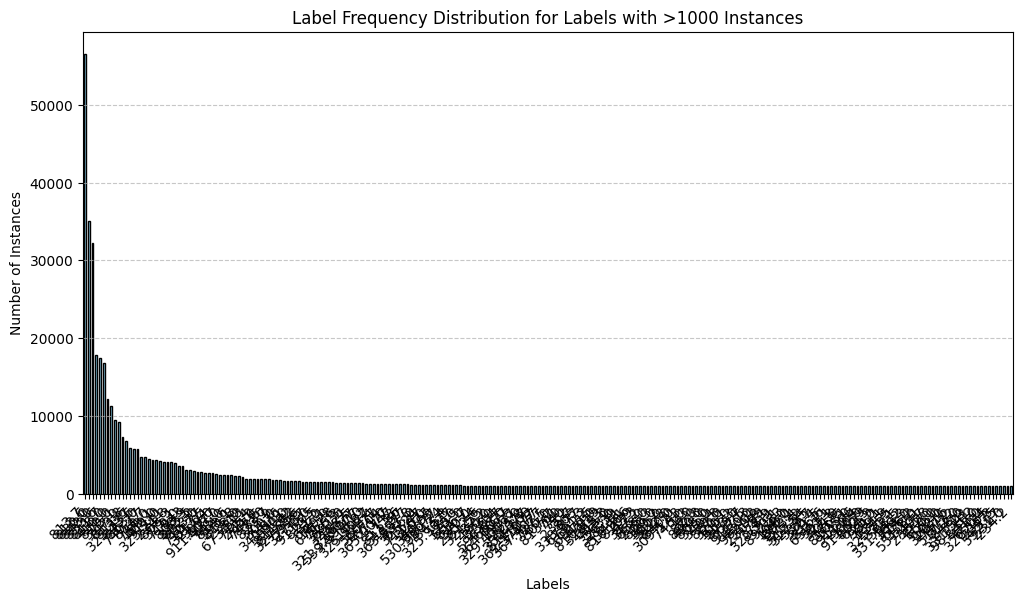

In [ ]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
augmented_df['KDC_NM'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Frequency Distribution for Labels with >1000 Instances')
plt.xlabel('Labels')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
augmented_df.shape

(294629, 4)

In [ ]:
len(augmented_df['KDC_NM'].value_counts())

24

In [ ]:
augmented_df['KDC_NM'].value_counts()

,count
KDC_NM,
813.7,56540
813.6,35036
830.0,32274
843.0,17811
833.6,17427
811.7,16841
818.0,12151
410.0,11279
810.0,9428


### Random Under Sampling

In [ ]:
from sklearn.utils import resample

def random_undersample(data, label_column, target_count):
    """
    지정된 target_count보다 많은 라벨의 데이터를 랜덤하게 줄이는 함수.

    Args:
        data (pd.DataFrame): 원본 데이터프레임
        label_column (str): 라벨 컬럼명
        target_count (int): 목표 라벨의 최소 인스턴스 수

    Returns:
        pd.DataFrame: 랜덤 언더샘플링 후의 데이터프레임
    """
    undersampled_data = []

    # 각 라벨별 인스턴스 개수 세기
    label_counts = data[label_column].value_counts()

    for label, count in label_counts.items():
        label_data = data[data[label_column] == label]

        # 라벨의 개수가 target_count보다 많을 경우 랜덤하게 줄이기
        if count > target_count:
            # target_count로 샘플링
            label_data = resample(label_data,
                                  replace=False,  # 샘플링은 중복 없이
                                  n_samples=target_count,  # 지정된 개수만큼
                                  random_state=42)

        # 언더샘플링된 데이터 저장
        undersampled_data.append(label_data)

    # 리스트로 저장된 모든 데이터를 하나로 합침
    final_data = pd.concat(undersampled_data, ignore_index=True)

    return final_data

In [ ]:
final_df = random_undersample(augmented_df, "KDC_NM", 10000)

In [ ]:
final_df.shape

(452541, 4)

In [ ]:
final_df.isna().sum()

,0
TITLE_NM,0
ISBN_THIRTEEN_NO,0
KDC_NM,0
description,0


In [ ]:
final_df = final_df.dropna(subset=['description'])

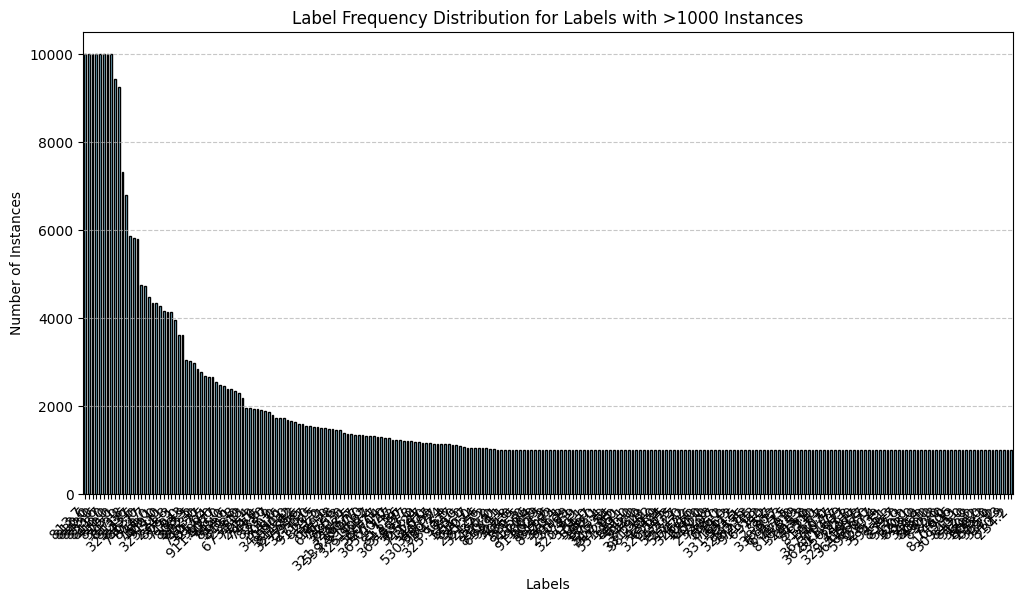

In [ ]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
final_df['KDC_NM'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Frequency Distribution for Labels with >1000 Instances')
plt.xlabel('Labels')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
len(final_df['KDC_NM'].unique())

248

## (3) 토큰 수 managing

In [ ]:
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-g9bmpitx/kobert-tokenizer_67e9c43fdc0b4db29e6c4008f6f667ff
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-g9bmpitx/kobert-tokenizer_67e9c43fdc0b4db29e6c4008f6f667ff
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=3adaf776257d6702f7c3e555b245ec1fb06b362ad1a6fd7e98c67663d0504d90
  Stored in directory: /tmp/pip-ephem-wheel-cache-oqjtt5rc/wheels/b7/95/7c/3f38b039ae9422cc4a51702b37e352d0585442cbe60285f1f2
Successfully built kobert_tokenizer


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


평균 토큰 수: 97.25763853440904
최대 토큰 수: 11873
최소 토큰 수: 1


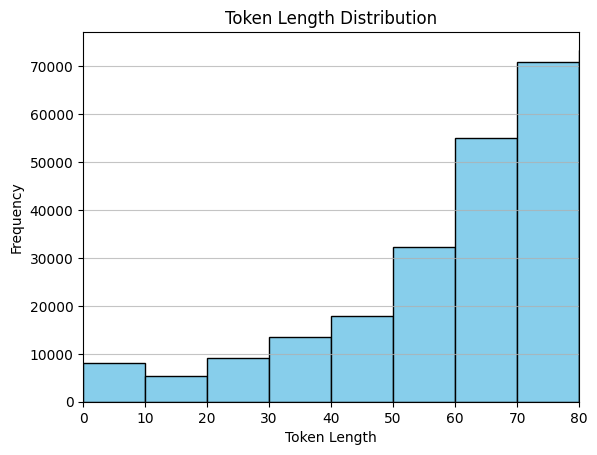

In [ ]:
import matplotlib.pyplot as plt
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertTokenizer

# KoBERT 토크나이저 로드
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

# 텍스트 데이터를 토큰화하고 각 텍스트의 토큰 수를 계산
token_lengths = final_df["description"].astype(str).apply(lambda x: len(tokenizer.tokenize(x)))

# 평균, 최대, 최소값 계산
average_length = token_lengths.mean()
max_length = token_lengths.max()
min_length = token_lengths.min()

print(f"평균 토큰 수: {average_length}")
print(f"최대 토큰 수: {max_length}")
print(f"최소 토큰 수: {min_length}")

# 히스토그램 시각화
plt.hist(token_lengths, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color='skyblue', edgecolor='black')
plt.xlim(left=0,right=80)  # xlim(right=값)으로 최대값을 설정
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [ ]:
# 90%, 95% 백분위수 계산
percentile_90 = np.percentile(token_lengths, 90)
percentile_95 = np.percentile(token_lengths, 95)

print(f"90% 백분위수: {percentile_90}")
print(f"95% 백분위수: {percentile_95}")

90% 백분위수: 134.0
95% 백분위수: 222.0


In [ ]:
count_over_240 = (token_lengths >= 221).sum()
print(f"토큰 개수가 240개 이상인 행의 개수: {count_over_240}")

토큰 개수가 240개 이상인 행의 개수: 22871


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertTokenizer
from nltk.tokenize import sent_tokenize  # 문장 분리를 위해 NLTK 사용

# KoBERT Tokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

# 한국어 불용어 목록
stopwords = [
    '이', '그', '저', '것', '수', '등', '들', '이다', '가', '이', '그렇다', '의', '에', '에서', '를', '으로',
    '고', '한', '과', '도', '만', '보다', '다', '좀', '자'
]

def summarize_by_tfidf(df, column_name, token_limit, top_n=3):
    # 토큰 수 계산 함수
    def token_count(text):
        return len(tokenizer.tokenize(text))

    # 새로운 열에 토큰 수 추가
    df['token_count'] = df[column_name].apply(token_count)

    # 토큰 수가 일정 이상인 데이터만 추출
    df_to_summarize = df[df['token_count'] >= token_limit]

    # 문장 단위 TF-IDF 요약 함수
    def summarize_tfidf_sentences(text, ngram_range=(1, 1), top_n=3):
        # 텍스트를 문장 단위로 분리
        sentences = sent_tokenize(text)

        if len(sentences) <= top_n:
            return text  # 문장이 적으면 전체 반환

        # TF-IDF 벡터라이저 생성
        vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=ngram_range)
        tfidf_matrix = vectorizer.fit_transform(sentences)

        # TF-IDF 점수를 합산하여 중요한 문장을 찾음
        scores = np.array(tfidf_matrix.sum(axis=1)).flatten()

        # 상위 N개의 점수를 가진 문장 선택
        top_indices = scores.argsort()[-top_n:][::-1]  # 중요도 높은 인덱스 정렬

        # 인덱스를 정수 리스트로 변환
        top_indices = top_indices.tolist()

        # 중요한 문장만 반환
        important_sentences = [sentences[i] for i in top_indices]
        return ' '.join(important_sentences)

    # 각 텍스트에 대해 TF-IDF로 중요한 문장 추출
    df_to_summarize[column_name] = df_to_summarize[column_name].apply(
        lambda text: summarize_tfidf_sentences(text, top_n=top_n)
    )

    # 원본 데이터프레임에 요약된 텍스트 대체
    df.update(df_to_summarize)

    # 불필요한 열 제거
    df.drop(columns=['token_count'], inplace=True)

    return df

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# 예시 데이터프레임
data = {
    'text': [
        '<하루 5분 엄마 목소리〉로 태교 동화에 새로운 방향을 제시한 정홍 작가의 후속작 〈하루 5분 아빠 목소리〉가 출간된다. 전편이 엄마를 위한 책이었다면, 이번은 아빠를 위한 창작 동화 10편으로 구성되어 있다. 많은 독자들로부터 사랑 받은 〈하루 5분 엄마 목소리〉와 같은 구성으로, ‘아빠를 위한 동화’와 ‘아기에게 읽어주는 짧은 태교 동화’가 함께 수록되어 있다. 그리고 동화를 읽고 난 후 아빠의 생각을 정리해 아이에게 전달해주는 ‘아빠의 생각보따리’로 덧붙여 있다. 특히 전편에서 동화를 통해 아기에게 사랑을 듬뿍 전해줄 수 있었다면, 이번 아빠의 태교 동화는 삶을 살아갈 때 힘이 되어줄 지혜를 키우는 이야기들로 구성되어 있다.',
        '사면 오르는 미국 주식, 이제 당신도 찾을 수 있습니다. 33만 구독자가 신뢰하는 ‘미주은’의 미국 주식 투자 교과서 주가가 오르면 따라가고, 떨어지면 불안해하며 팔아버리는 악순환. 수익이 났다가도 금세 사라지고, 종목을 고를 때마다 불안과 초조함이 앞서는 경험은 누구에게나 낯설지 않다. 『미국 주식 투자의 정석』은 바로 이런 고민에 빠진 개인 투자자들을 위해 탄생한 책이다. 저자 미주은은 지난 5년간 매일 10시간 이상을 주식과 씨름하며 실전 경험과 방대한 지식을 쌓아왔다. 그는 ‘투자에서 실패하는 가장 큰 이유는 명확한 투자 기준이 없기 때문’이라고 강조한다. 감정에 휘둘리는 투자에서 벗어나 논리적이고 체계적인 기준을 세워야만, 시장의 오르내림에 흔들리지 않고 꾸준히 성공적인 투자를 이어갈 수 있다. 이 책은 왜 미국 주식이어야 하는지부터 시작해, 실패를 줄이고 성공 확률을 높이는 방법, 그리고 데이터에 기반한 확실한 투자 전략까지를 총망라했다. 특히, 매크로 경제와 시장 심리 분석, 종목 선정 기준, 차트를 활용한 실전 투자법까지 아우르며 개인 투자자에게 실질적인 도움을 제공한다. 어떤 종목을 사야 할지, 언제 사고팔아야 할지 몰라 막막했던 개인 투자자들에게 『미국 주식 투자의 정석』은 명확한 투자 방향을 제시한다. 초보 투자자는 물론, 기존 투자에서 실패를 경험했거나 재도약하려는 중급 투자자까지 폭넓게 적용할 수 있다. 이 책이 특별한 이유 왜 미국 주식이어야 하는가: 글로벌 시장에서 미국 주식이 주는 기회 실패를 줄이는 투자 원칙: 흔히 빠지는 함정을 극복하는 법 종목 선택의 비밀: 미래를 이끄는 최고의 성장주 찾는 법 경제 흐름 읽기: 연준의 금리와 경제 지표 활용법 성공적인 투자 심리 관리: FOMO(놓칠 것 같은 두려움) 극복과 논리적 사고의 중요성 이제 더 이상 주가의 오르내림에 흔들릴 필요 없다. 『미국 주식 투자의 정석』과 함께라면 반복되는 투자 실패와 불안은 사라지고, 그 자리를 확신과 자신감이 채울 것이다. 명확한 투자 전략으로 흔들리지 않는 당신만의 포트폴리오를 설계해 보자.',
        'KoBERT는 한국어에 특화된 BERT 모델입니다.',
        '짧은 문장.'
    ]
}

df = pd.DataFrame(data)

# TF-IDF 요약 수행
summarized_df = summarize_by_tfidf(df, 'text',5)

# 결과 출력
print(summarized_df)

                                                text
0  특히 전편에서 동화를 통해 아기에게 사랑을 듬뿍 전해줄 수 있었다면, 이번 아빠의 ...
1  이 책이 특별한 이유 왜 미국 주식이어야 하는가: 글로벌 시장에서 미국 주식이 주는...
2                       KoBERT는 한국어에 특화된 BERT 모델입니다.
3                                             짧은 문장.


<ipython-input-51-b7c10c7ff5ad>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_summarize[column_name] = df_to_summarize[column_name].apply(


In [ ]:
final_df = summarize_by_tfidf(final_df, 'description', token_limit=221)

<ipython-input-51-b7c10c7ff5ad>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_summarize[column_name] = df_to_summarize[column_name].apply(


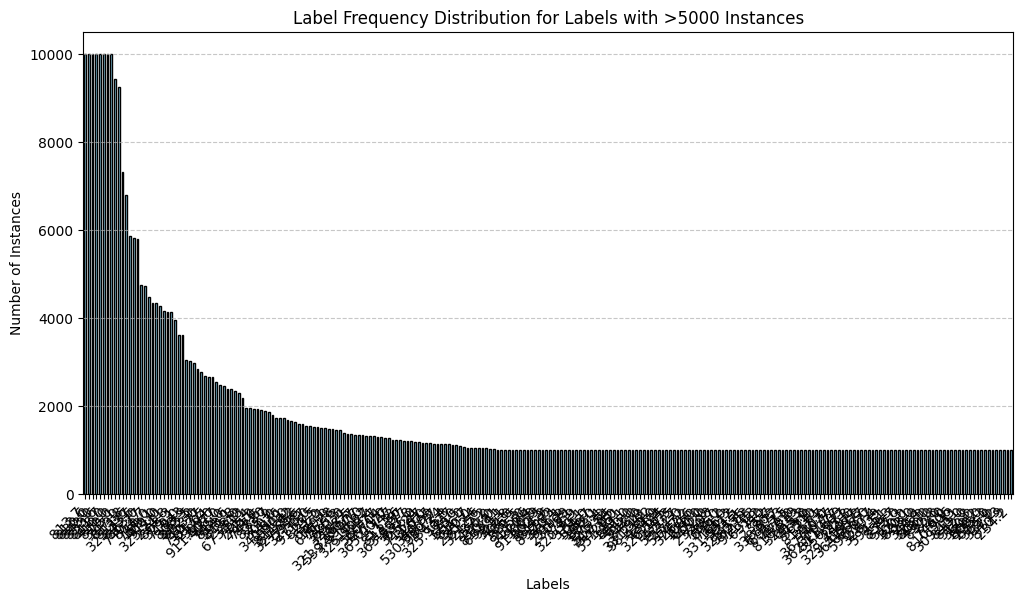

In [ ]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
final_df['KDC_NM'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Frequency Distribution for Labels with >5000 Instances')
plt.xlabel('Labels')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
len(final_df['KDC_NM'].unique())

248

# KoBERT Model

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 48.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp311-cp311-linux_x86_64.whl size=679483 sha256=726da97a01f2812d1e67852164a11d2a2b6a9e15abf562de100932ad3bd0825a
  Stored in directory: /root/.cache/pip/wheels/29/64/e3/047328bfc4a551696adc4a82dba3c980a1dad62198b8a3bb83
Successfully built gluonnlp


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


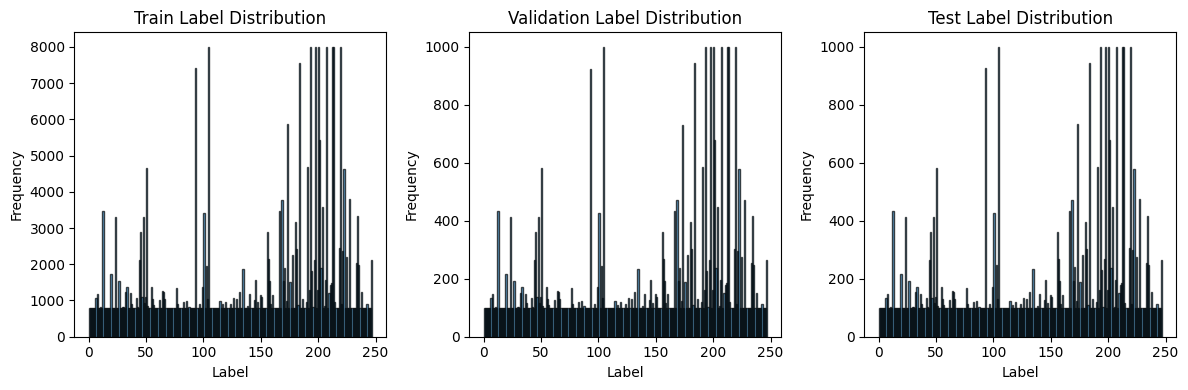

248


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, tqdm_notebook
from kobert_tokenizer import KoBERTTokenizer
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer, BertModel, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast

# 데이터셋 정의
class BookDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(data['KDC_NM'].dropna().astype(str).unique()))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        title = item['TITLE_NM']
        description = item['description']
        label = str(item['KDC_NM'])

        label_idx = self.label_to_index[label]

        input_text = title + " " + description
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': label_idx
        }

# 모델 정의
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

        for param in self.bert.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

# 하이퍼파라미터
MAX_LENGTH = 221
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPOCHS = 40
GRAD_ACCUMULATION_STEPS = 4

# 데이터 준비
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
dataset = BookDataset(final_df, tokenizer, MAX_LENGTH)

# 데이터셋 나누기
labels = final_df['KDC_NM'].astype(str).values
indices = list(range(len(final_df)))

train_indices, temp_indices = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[labels[i] for i in temp_indices], random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)

# 데이터셋에서 라벨 추출
train_labels = [sample['label'] for sample in train_dataset]
val_labels = [sample['label'] for sample in val_dataset]
test_labels = [sample['label'] for sample in test_dataset]

# 라벨 분포 시각화
plt.figure(figsize=(12, 4))

# Train 데이터셋 라벨 분포
plt.subplot(1, 3, 1)
plt.hist(train_labels, bins=np.arange(min(train_labels), max(train_labels)+1, 1), edgecolor='black', alpha=0.7)
plt.title('Train Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Validation 데이터셋 라벨 분포
plt.subplot(1, 3, 2)
plt.hist(val_labels, bins=np.arange(min(val_labels), max(val_labels)+1, 1), edgecolor='black', alpha=0.7)
plt.title('Validation Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Test 데이터셋 라벨 분포
plt.subplot(1, 3, 3)
plt.hist(test_labels, bins=np.arange(min(test_labels), max(test_labels)+1, 1), edgecolor='black', alpha=0.7)
plt.title('Test Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 데이터셋에서 레이블별 샘플 개수 계산
from collections import Counter

# Extract labels from the dataset's data attribute
labels = dataset.data['KDC_NM'].astype(str).tolist()
label_counts = Counter([dataset.label_to_index[label] for label in labels])

# 클래스 가중치 계산: 전체 샘플 수 / (클래스 수 * 해당 클래스 샘플 수)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(dataset.label_to_index)  # Replace with your model's actual number of output classes
total_samples = sum(label_counts.values())
print(num_classes)

# 가중치 리스트 초기화
class_weights = [total_samples / (num_classes * label_counts.get(i, 1)) for i in range(num_classes)]

# 가중치를 텐서로 변환
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
# 'KDC_NM' 열을 문자열로 변환
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)

# 데이터셋의 고유 라벨 확인
unique_labels = final_df['KDC_NM'].unique()
print(f"데이터셋 고유 라벨 개수: {len(unique_labels)}")

# 매핑 테이블 확인
print(f"매핑 테이블 크기: {len(dataset.label_to_index)}")  # 18141 출력 예상

# 매핑 테이블에 데이터셋의 고유 라벨이 모두 포함되어 있는지 확인
missing_labels = [label for label in unique_labels if label not in dataset.label_to_index]
if missing_labels:
    print(f"매핑되지 않은 라벨: {missing_labels}")
else:
    print("모든 라벨이 매핑되었습니다.")

데이터셋 고유 라벨 개수: 248
매핑 테이블 크기: 248
모든 라벨이 매핑되었습니다.


## 5000개 이상



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/40 [Validation]: 100%|██████████| 626/626 [00:14<00:00, 41.90it/s]


Epoch 1/40
Train Loss: 1.3271, Train Accuracy: 0.6118
Val Loss: 0.8631, Val Accuracy: 0.7230


Epoch 2/40 [Validation]: 100%|██████████| 626/626 [00:14<00:00, 41.89it/s]


Epoch 2/40
Train Loss: 0.8218, Train Accuracy: 0.7338
Val Loss: 0.7468, Val Accuracy: 0.7542


Epoch 3/40 [Validation]: 100%|██████████| 626/626 [00:14<00:00, 41.74it/s]


Epoch 3/40
Train Loss: 0.7198, Train Accuracy: 0.7604
Val Loss: 0.6850, Val Accuracy: 0.7636


Epoch 4/40 [Validation]: 100%|██████████| 626/626 [00:14<00:00, 41.88it/s]


Epoch 4/40
Train Loss: 0.6588, Train Accuracy: 0.7786
Val Loss: 0.6585, Val Accuracy: 0.7761


Epoch 5/40 [Validation]: 100%|██████████| 626/626 [00:14<00:00, 41.96it/s]


Epoch 5/40
Train Loss: 0.6092, Train Accuracy: 0.7932
Val Loss: 0.6365, Val Accuracy: 0.7835


Epoch 6/40 [Validation]: 100%|██████████| 626/626 [00:14<00:00, 41.83it/s]


Epoch 6/40
Train Loss: 0.5700, Train Accuracy: 0.8063
Val Loss: 0.6494, Val Accuracy: 0.7847


Epoch 7/40 [Validation]: 100%|██████████| 626/626 [00:15<00:00, 41.71it/s]


Epoch 7/40
Train Loss: 0.5325, Train Accuracy: 0.8170
Val Loss: 0.6249, Val Accuracy: 0.7877


Epoch 8/40 [Validation]: 100%|██████████| 626/626 [00:15<00:00, 41.47it/s]


Epoch 8/40
Train Loss: 0.5018, Train Accuracy: 0.8273
Val Loss: 0.6065, Val Accuracy: 0.7926


Epoch 9/40 [Validation]: 100%|██████████| 626/626 [00:15<00:00, 41.70it/s]


Epoch 9/40
Train Loss: 0.4705, Train Accuracy: 0.8368
Val Loss: 0.6013, Val Accuracy: 0.8016


Epoch 10/40 [Validation]: 100%|██████████| 626/626 [00:15<00:00, 41.59it/s]


Epoch 10/40
Train Loss: 0.4499, Train Accuracy: 0.8447
Val Loss: 0.6006, Val Accuracy: 0.8038


Epoch 11/40 [Validation]: 100%|██████████| 626/626 [00:14<00:00, 41.82it/s]


Epoch 11/40
Train Loss: 0.4254, Train Accuracy: 0.8527
Val Loss: 0.6139, Val Accuracy: 0.7932


Epoch 12/40 [Validation]: 100%|██████████| 626/626 [00:14<00:00, 41.77it/s]


Epoch 12/40
Train Loss: 0.4066, Train Accuracy: 0.8597
Val Loss: 0.5882, Val Accuracy: 0.8070


Epoch 13/40 [Validation]: 100%|██████████| 626/626 [00:15<00:00, 41.37it/s]


Epoch 13/40
Train Loss: 0.3782, Train Accuracy: 0.8698
Val Loss: 0.5943, Val Accuracy: 0.8047


Epoch 14/40 [Validation]: 100%|██████████| 626/626 [00:15<00:00, 41.40it/s]


Epoch 14/40
Train Loss: 0.3612, Train Accuracy: 0.8749
Val Loss: 0.6061, Val Accuracy: 0.8024


Epoch 15/40 [Validation]: 100%|██████████| 626/626 [00:14<00:00, 41.78it/s]


Epoch 15/40
Train Loss: 0.3404, Train Accuracy: 0.8814
Val Loss: 0.6096, Val Accuracy: 0.8073
Early stopping at epoch 15 due to no improvement in validation loss.


Testing: 100%|██████████| 626/626 [00:58<00:00, 10.69it/s]



Test Set Performance:
F1 Micro: 0.8059, F1 Macro: 0.8075
Recall Micro: 0.8059, Recall Macro: 0.8121, ROC AUC: 0.0000


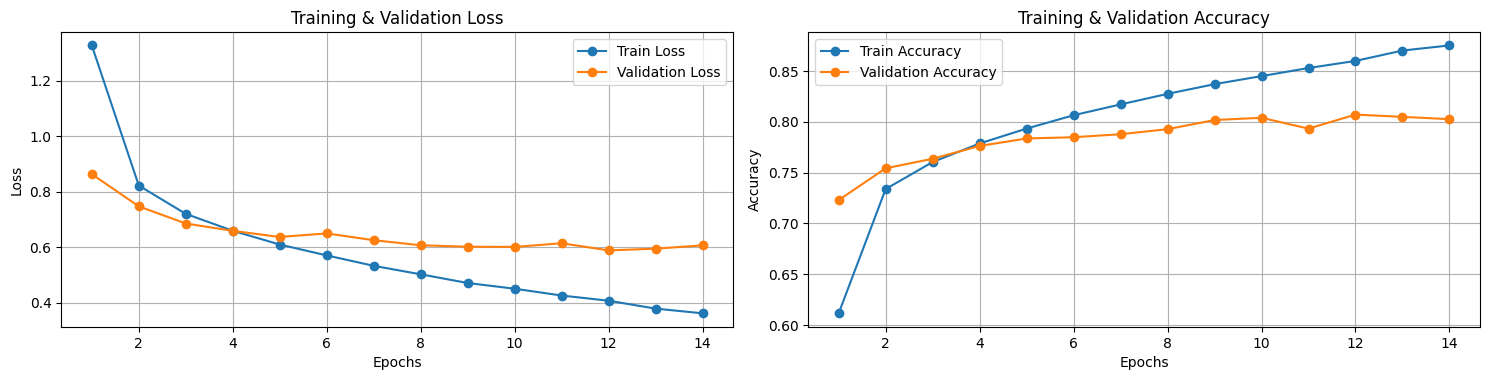

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np

# 모델 준비
bert_model = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=True)
model = BERTClassifier(bert_model, len(dataset.label_to_index))
model.to(device)

# 옵티마이저 및 스케줄러
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
scaler = GradScaler()

# 정확도 계산 함수
def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

# Early Stopping 설정
best_val_loss = float('inf')
patience = 3  # 성능 향상이 없는 epoch 수
patience_counter = 0

# 모델 저장 경로
best_model_path = "best_model.pth"

# 학습 및 검증 기록을 저장할 리스트
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# 학습 및 검증 루프
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_acc = 0

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Training]")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with autocast():
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels) / GRAD_ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % GRAD_ACCUMULATION_STEPS == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * GRAD_ACCUMULATION_STEPS
        total_acc += calculate_accuracy(logits, labels)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)

    # 검증 루프
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validation]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with autocast():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

            val_loss += loss.item()
            val_acc += calculate_accuracy(logits, labels)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # 학습/검증 손실 및 정확도 출력
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc:.4f}")

    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # 성능 향상 시 카운터 초기화
        torch.save(model.state_dict(), best_model_path)  # 가장 좋은 모델 저장
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
        break

    # 리스트에 값 저장
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

# 🔹 학습이 끝난 후, 가장 잘 나온 모델 불러오기
model.load_state_dict(torch.load(best_model_path))

# 🔹 학습이 끝난 후 테스트 세트에서 F1, Recall, ROC AUC 계산
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)

        # 예측값 저장
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        # 확률값 저장 (softmax)
        probabilities = F.softmax(logits, dim=1)  # 각 클래스에 대한 확률
        test_probabilities.extend(probabilities.cpu().numpy())

# F1 Score, Recall, ROC AUC 계산 (테스트 세트에서)
f1_micro = precision_recall_fscore_support(test_labels, test_preds, average="micro")[2]
f1_macro = precision_recall_fscore_support(test_labels, test_preds, average="macro")[2]

recall_micro = precision_recall_fscore_support(test_labels, test_preds, average="micro")[1]
recall_macro = precision_recall_fscore_support(test_labels, test_preds, average="macro")[1]

try:
    roc_auc = roc_auc_score(test_labels, test_probabilities, multi_class="ovr")
except ValueError:
    roc_auc = 0  # 예외 처리 (ROC AUC 계산 불가할 경우 0으로 설정)

# Accuracy 계산
test_accuracy = calculate_accuracy(np.array(test_preds), np.array(test_labels))

# 테스트 세트 성능 출력
print(f"\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Micro: {f1_micro:.4f}, F1 Macro: {f1_macro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}, Recall Macro: {recall_macro:.4f}, ROC AUC: {roc_auc:.4f}")

# 🔹 학습이 끝난 후 결과 시각화
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 7))

# Loss 그래프
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Accuracy 그래프
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Testing for Confusion Matrix: 100%|██████████| 626/626 [00:15<00:00, 41.69it/s]


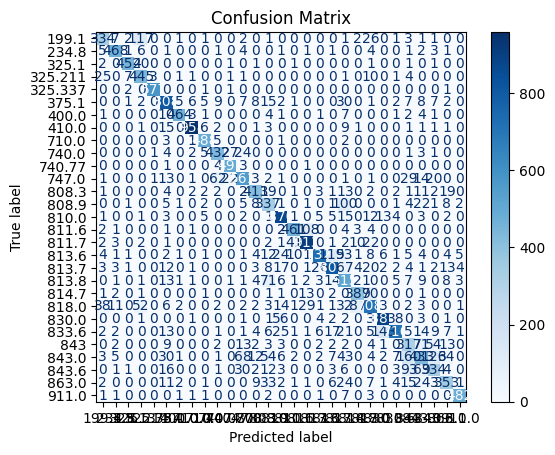

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix 계산 및 시각화
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing for Confusion Matrix"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with autocast():
            logits = model(input_ids, attention_mask)

        preds = torch.argmax(logits, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion Matrix 생성
conf_matrix = confusion_matrix(all_labels, all_preds)

# 클래스 이름 (라벨) 추출
class_names = [key for key, _ in sorted(dataset.label_to_index.items(), key=lambda x: x[1])]

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Confusion Matrix에서 가장 큰 오차를 가진 클래스 쌍 추출
error_matrix = conf_matrix.copy()
np.fill_diagonal(error_matrix, 0)  # 정확한 예측 제거
top_misclassifications = np.unravel_index(np.argsort(error_matrix, axis=None)[-10:], error_matrix.shape)

# 상위 혼동 클래스 출력
for true_class, pred_class in zip(*top_misclassifications):
    print(f"True: {class_names[true_class]}, Predicted: {class_names[pred_class]}, Count: {error_matrix[true_class, pred_class]}")

True: 818.0, Predicted: 814.7, Count: 87
True: 814.7, Predicted: 818.0, Count: 90
True: 843.6, Predicted: 843, Count: 93
True: 808.9, Predicted: 813.8, Count: 100
True: 811.6, Predicted: 811.7, Count: 108
True: 199.1, Predicted: 325.211, Count: 117
True: 813.6, Predicted: 813.7, Count: 119
True: 843.0, Predicted: 843.6, Count: 126
True: 833.6, Predicted: 830.0, Count: 143
True: 843.0, Predicted: 843, Count: 160


## 1000개 이상

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np

# 모델 준비
bert_model = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=True)
model = BERTClassifier(bert_model, len(dataset.label_to_index))
model.to(device)

# 옵티마이저 및 스케줄러
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
scaler = GradScaler()

# 정확도 계산 함수
def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

# Early Stopping 설정
best_val_loss = float('inf')
patience = 3  # 성능 향상이 없는 epoch 수
patience_counter = 0

# 모델 저장 경로
best_model_path = "best_model.pth"

# 학습 및 검증 기록을 저장할 리스트
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# 학습 및 검증 루프
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_acc = 0

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Training]")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with autocast():
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels) / GRAD_ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % GRAD_ACCUMULATION_STEPS == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * GRAD_ACCUMULATION_STEPS
        total_acc += calculate_accuracy(logits, labels)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)

    # 검증 루프
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validation]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            with autocast():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

            val_loss += loss.item()
            val_acc += calculate_accuracy(logits, labels)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # 학습/검증 손실 및 정확도 출력
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc:.4f}")

    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # 성능 향상 시 카운터 초기화
        torch.save(model.state_dict(), best_model_path)  # 가장 좋은 모델 저장
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
        break

    # 리스트에 값 저장
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

# 🔹 학습이 끝난 후, 가장 잘 나온 모델 불러오기
model.load_state_dict(torch.load(best_model_path))

# 🔹 학습이 끝난 후 테스트 세트에서 F1, Recall, ROC AUC 계산
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)

        # 예측값 저장
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        # 확률값 저장 (softmax)
        probabilities = F.softmax(logits, dim=1)  # 각 클래스에 대한 확률
        test_probabilities.extend(probabilities.cpu().numpy())

# F1 Score, Recall, ROC AUC 계산 (테스트 세트에서)
f1_micro = precision_recall_fscore_support(test_labels, test_preds, average="micro")[2]
f1_macro = precision_recall_fscore_support(test_labels, test_preds, average="macro")[2]

recall_micro = precision_recall_fscore_support(test_labels, test_preds, average="micro")[1]
recall_macro = precision_recall_fscore_support(test_labels, test_preds, average="macro")[1]

try:
    roc_auc = roc_auc_score(test_labels, test_probabilities, multi_class="ovr")
except ValueError:
    roc_auc = 0  # 예외 처리 (ROC AUC 계산 불가할 경우 0으로 설정)

# Accuracy 계산
test_accuracy = calculate_accuracy(np.array(test_preds), np.array(test_labels))

# 테스트 세트 성능 출력
print(f"\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Micro: {f1_micro:.4f}, F1 Macro: {f1_macro:.4f}")
print(f"Recall Micro: {recall_micro:.4f}, Recall Macro: {recall_macro:.4f}, ROC AUC: {roc_auc:.4f}")

# 🔹 학습이 끝난 후 결과 시각화
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 7))

# Loss 그래프
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Accuracy 그래프
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.39it/s]


Epoch 1/40
Train Loss: 3.1544, Train Accuracy: 0.4286
Val Loss: 1.7286, Val Accuracy: 0.5808


Epoch 2/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.40it/s]


Epoch 2/40
Train Loss: 1.4802, Train Accuracy: 0.5899
Val Loss: 1.2283, Val Accuracy: 0.5920


Epoch 3/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.41it/s]


Epoch 3/40
Train Loss: 1.1236, Train Accuracy: 0.6218
Val Loss: 1.0831, Val Accuracy: 0.6320


Epoch 4/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.38it/s]


Epoch 4/40
Train Loss: 0.9842, Train Accuracy: 0.6436
Val Loss: 0.9994, Val Accuracy: 0.6586


Epoch 5/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.38it/s]


Epoch 5/40
Train Loss: 0.8961, Train Accuracy: 0.6618
Val Loss: 0.9680, Val Accuracy: 0.6740


Epoch 6/40 [Validation]: 100%|██████████| 1415/1415 [03:12<00:00,  7.36it/s]


Epoch 6/40
Train Loss: 0.8352, Train Accuracy: 0.6784
Val Loss: 0.9349, Val Accuracy: 0.6783


Epoch 7/40 [Validation]: 100%|██████████| 1415/1415 [03:12<00:00,  7.34it/s]


Epoch 7/40
Train Loss: 0.7810, Train Accuracy: 0.6909
Val Loss: 0.9149, Val Accuracy: 0.6714


Epoch 8/40 [Validation]: 100%|██████████| 1415/1415 [03:11<00:00,  7.40it/s]


Epoch 8/40
Train Loss: 0.7283, Train Accuracy: 0.7032
Val Loss: 0.8845, Val Accuracy: 0.6850


Epoch 9/40 [Training]:  91%|█████████ | 10293/11314 [1:05:58<06:29,  2.62it/s]